### Set up library

In [31]:
%cd /home/wetu/bmo/Thesis_Research
!ls

/home/wetu/bmo/Thesis_Research
data			   lstm_autoencoder_model_aa.pt  train
keypoint_extraction.ipynb  model			 t-sne_1worker.npy
keypoint_hidden_array.npy  output.avi			 t-SNE.png
keypointloader		   real_time_detection.ipynb	 t_SNE.png
keypoints_1worker.npy	   result			 video_record.py
keypoints_array.npy	   test
keypoints_worker_demo.npy  test_video.mp4


In [32]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
%matplotlib inline
from keypointloader.vae_dataloader import sequence_data
from sklearn.model_selection import train_test_split
from torch.utils.data import  DataLoader
from model.predict_reconstruct import RNN_VAE
from model.vae_model import VAutoencoder
import torch

In [33]:


input_size = 66
hidden_size = 32#64#1024
num_layers = 2
dropout_encoder = 0.2
dropout_rec = 0.2
dropout_pred = 0.2
softplus = False
SNAPSHOT = 50

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'now device is running on {device}')

now device is running on cuda


### Load Dataset


(47742, 33, 2)
(47742, 66)


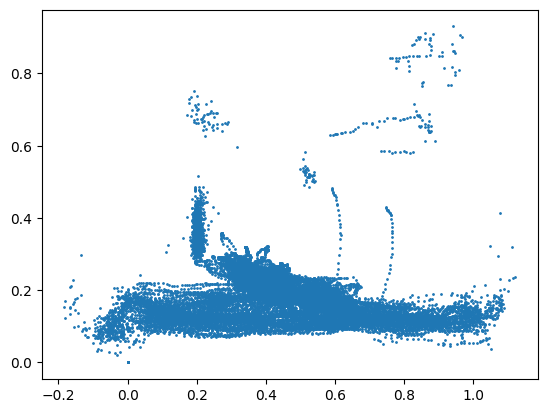

In [35]:
data_path = "/home/wetu/bmo/Thesis_Research/keypoints_array.npy"
keypoints = np.load(data_path)
print(keypoints.shape)
keypoints = keypoints.reshape(-1,66)
print(keypoints.shape)
plt.scatter(keypoints[:,0],keypoints[:,1],s=1)
plt.show()


### Split data

keypoint is split to training with (42967, 66) points


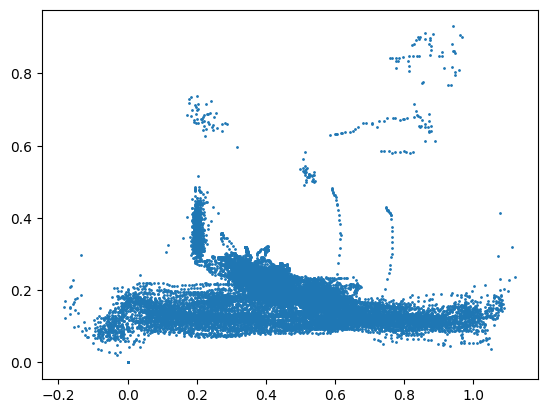

In [36]:

X_train, X_test = train_test_split(keypoints, test_size=0.1, random_state=42)
print(f"keypoint is split to training with {X_train.shape} points")
plt.scatter(X_train[:,0],X_train[:,1],s=1)
plt.show()
del keypoints

### Data visualization

In [37]:
batch_size = 32
training_set = sequence_data(X_train,model_mode = 1,seq_len=30)

data_loader = DataLoader(training_set,batch_size = batch_size, shuffle = True)

In [38]:
'''from scipy.stats import norm
mean = np.mean(X_train)
std = np.std(X_train)

x = np.linspace(mean-3*std,mean+3*std,100)
y = norm.pdf(x,mean,std)
plt.figure(figsize=(8,6))
plt.hist(X_train,density=True,bins = 30, alpha = 0.5)
#plt.plot(x,y,'r-',linewidth = 2)'''

"from scipy.stats import norm\nmean = np.mean(X_train)\nstd = np.std(X_train)\n\nx = np.linspace(mean-3*std,mean+3*std,100)\ny = norm.pdf(x,mean,std)\nplt.figure(figsize=(8,6))\nplt.hist(X_train,density=True,bins = 30, alpha = 0.5)\n#plt.plot(x,y,'r-',linewidth = 2)"

In [39]:
# Example of iterating over the DataLoader
for i, data in enumerate(data_loader):
    print(f"Batch {i+1}")
    print(data.shape)
    print("-----------")

    # Stop after a few batches for testing
    if i == 2:  # Change this number to print more or fewer batches
        break

Batch 1
torch.Size([32, 30, 66])
-----------
Batch 2
torch.Size([32, 30, 66])
-----------
Batch 3
torch.Size([32, 30, 66])
-----------


In [40]:
print(len(data_loader))


1342


### Define training function

In [41]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [42]:
def reconstruction_loss(input, output):
    mse_loss = nn.MSELoss()
    rec_loss = mse_loss(output, input)
    return rec_loss
def future_reconstruction_loss(input, output):
    mse_loss = nn.MSELoss()
    rec_loss = mse_loss(output, input)
    return rec_loss

In [43]:
def train(train_loader, model, optimizer,seq_len, future_steps):
    model.train() # toggle model to train mode
    train_loss = 0.0
    mse_loss = 0.0
    fut_loss = 0.0
    loss = 0.0
    seq_len_half = int(seq_len / 2)
    for idx, data_item in enumerate(train_loader):
        data = data_item[:,:seq_len_half,:].type('torch.FloatTensor').to(device)
        fut = data_item[:,seq_len_half:seq_len_half+future_steps,:].type('torch.FloatTensor').to(device)
        data_tilde, future = model(data)

        rec_loss = reconstruction_loss(data_tilde, data)
        fut_rec_loss = future_reconstruction_loss(future, fut)
        loss = rec_loss + fut_rec_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 5)

        train_loss += loss.item()
        mse_loss += rec_loss.item()
        fut_loss += fut_rec_loss.item()
        # if idx % 1000 == 0:
        #     print('Epoch: %d.  loss: %.4f' %(epoch, loss.item()))

    print('Train loss: {:.3f}, MSE-Loss: {:.3f}, MSE-Future-Loss {:.3f}'.format(train_loss / idx, mse_loss / idx, fut_loss / idx))

    
    return  train_loss/idx, mse_loss/idx, fut_loss/idx


In [44]:
def train(train_loader, model, optimizer,seq_len, future_steps):
    model.train() # toggle model to train mode
    train_loss = 0.0
    mse_loss = 0.0
    fut_loss = 0.0
    loss = 0.0
    seq_len_half = int(seq_len / 2)
    for idx, data_item in enumerate(train_loader):
        data = data_item.type('torch.FloatTensor').to(device)
        data_tilde = model(data)

        rec_loss = reconstruction_loss(data_tilde, data)
        
        optimizer.zero_grad()
        rec_loss.backward()
        optimizer.step()
        
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 5)

        mse_loss += rec_loss.item()
        # if idx % 1000 == 0:
        #     print('Epoch: %d.  loss: %.4f' %(epoch, loss.item()))

    print(f'train lose : {mse_loss/idx}')

    
    return  mse_loss/idx


### AE Training Loop

In [45]:
model = RNN_VAE(input_size,60, hidden_size,num_layers,dropout_encoder, dropout_rec,dropout_pred, softplus)

model = model.to(device)

AttributeError: 'Encoder' object has no attribute 'n_layer'

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
EPOCHS = 250
learning_rate = 3e-4
sequence_length = 30
future_steps = 60
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
project_path = "/home/wetu/bmo/Thesis_Research/result/"
training_set = sequence_data(X_train,model_mode = 1,seq_len=30)
data_loader = DataLoader(training_set,batch_size = batch_size, shuffle = True)

In [ ]:
train_losses = []
kl_losses = []
mse_losses = []
fut_losses = []
print("Start training... ")
#(train_loader, model, optimizer,seq_len, future_steps)
for epoch in range(1,EPOCHS):
    print("Epoch: %d" %epoch)
    mse_loss = train(data_loader, model, optimizer,sequence_length,future_steps)
    # logging losses
    #train_losses.append(train_loss)
    mse_losses.append(mse_loss)
    #fut_losses.append(fut_loss)

    # save best model

    if epoch % SNAPSHOT == 0:
        print("Saving model snapshot!\n")
        torch.save(model.state_dict(), './lstm_autoencoder_model_aa.pt')

    #save logged losses
    '''np.save(os.path.join(project_path,'model','model_losses','train_losses_'), train_losses)
    np.save(os.path.join(project_path,'model','model_losses','mse_train_losses_'), mse_losses)
    np.save(os.path.join(project_path,'model','model_losses','fut_losses_'), fut_losses)'''
    
    print("\n")

Start training... 
Epoch: 1


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x128 and 64x32)

### VAE training loop

In [ ]:
model = VAutoencoder(input_size,hidden_size,LATENT_SIZE=16,NUM_LAYERS=num_layers,DROP_ENC=dropout_encoder, DROP_DEC=dropout_pred)

model = model.to(device)

In [ ]:
def reconstruction_loss(input, output):
    mse_loss = nn.MSELoss()
    rec_loss = mse_loss(output, input)
    return rec_loss
def future_reconstruction_loss(input, output):
    mse_loss = nn.MSELoss()
    rec_loss = mse_loss(output, input)
    return rec_loss
def kullback_leibler_loss(mu, logvar):
    KLD = -0.5*torch.mean(1+logvar-mu.pow(2)-logvar.exp())
    return KLD

In [ ]:
def train(train_loader, model, optimizer,seq_len, future_steps):
    model.train() # toggle model to train mode
    train_loss = 0.0
    mse_loss = 0.0
    kullback_loss = 0.0
    loss = 0.0
    seq_len_half = int(seq_len / 2)
    BETA = 0.5
    for idx, data_item in enumerate(train_loader):
        data = data_item.type('torch.FloatTensor').to(device)
        data_tilde,z,mu,logvar = model(data)

        rec_loss = reconstruction_loss(data_tilde, data)
        kl_loss = kullback_leibler_loss(mu,logvar)
        loss = rec_loss+BETA*kl_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 5)

        mse_loss += rec_loss.item()
        kullback_loss += kl_loss.item()
        train_loss += loss.item()
        # if idx % 1000 == 0:
        #     print('Epoch: %d.  loss: %.4f' %(epoch, loss.item()))

    print(f'train lose : {mse_loss/idx}')

    
    return  train_loss/idx,mse_loss/idx,kullback_loss/idx


In [ ]:
train_losses = []
kl_losses = []
mse_losses = []
fut_losses = []
print("Start training... ")
#(train_loader, model, optimizer,seq_len, future_steps)
for epoch in range(1,EPOCHS):
    print("Epoch: %d" %epoch)
    train_loss,mse_loss,kl_loss = train(data_loader, model, optimizer,sequence_length,future_steps)
    # logging losses
    train_losses.append(train_loss)
    mse_losses.append(mse_loss)
    kl_losses.append(kl_loss)

    # save best model

    if epoch % SNAPSHOT == 0:
        print("Saving model snapshot!\n")
        torch.save(model.state_dict(), './lstm_autoencoder_model_aa.pt')

    #save logged losses
    '''np.save(os.path.join(project_path,'model','model_losses','train_losses_'), train_losses)
    np.save(os.path.join(project_path,'model','model_losses','mse_train_losses_'), mse_losses)
    np.save(os.path.join(project_path,'model','model_losses','fut_losses_'), fut_losses)'''
    
    print("\n")

### Plot Result

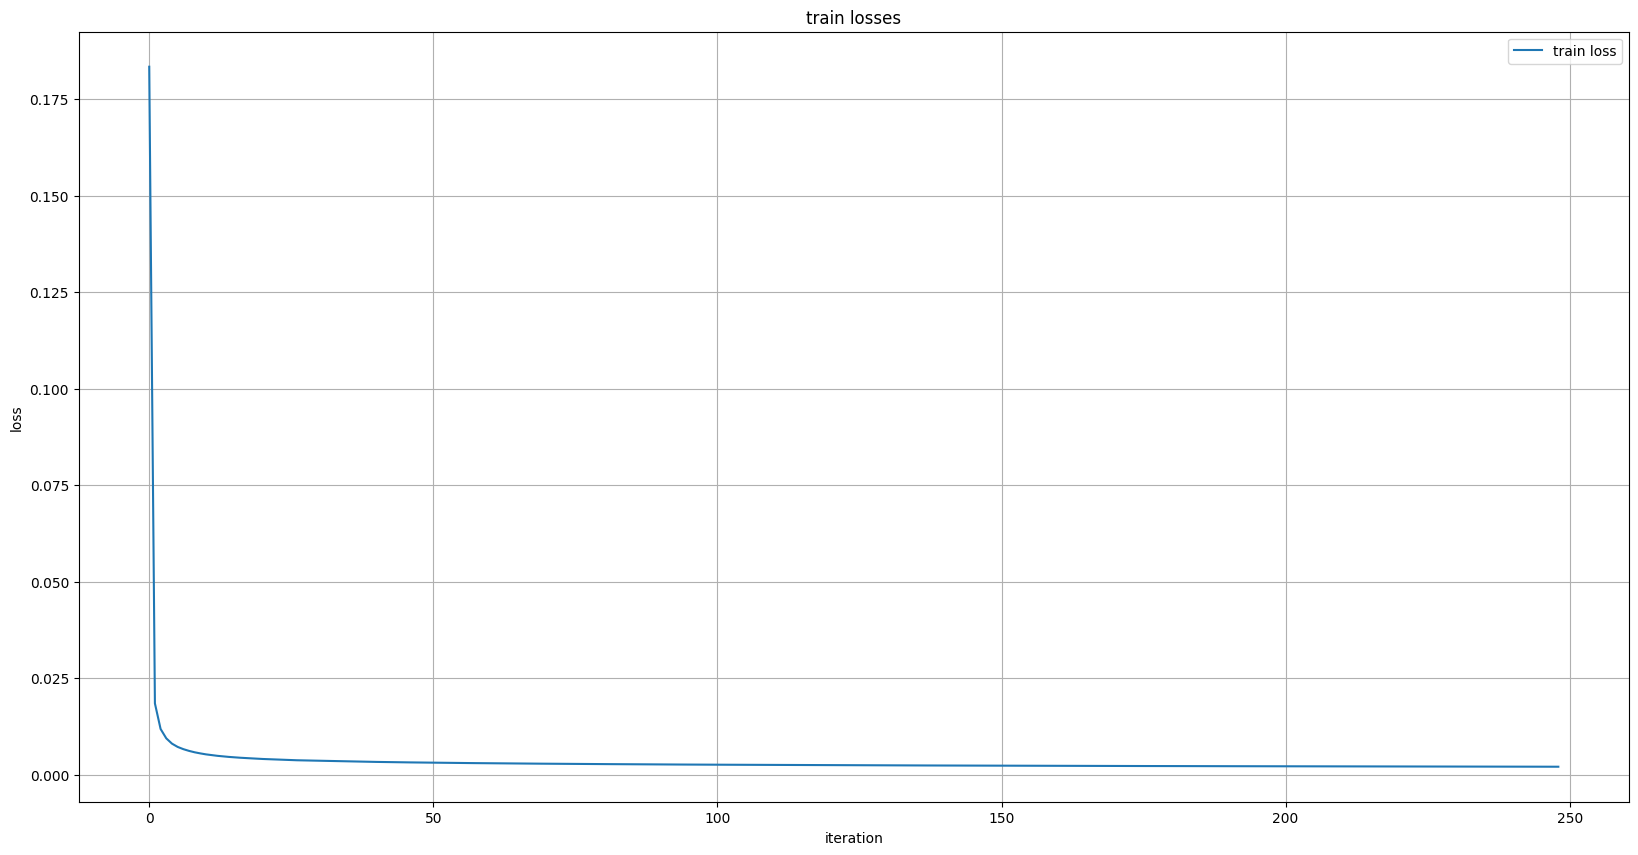

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(mse_losses, label='{} loss'.format("train"))
 
plt.legend()

plt.title('train losses')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.grid(True)

### Last Hidden State extraction

In [ ]:
model_path = "/home/wetu/bmo/Thesis_Research/result/ED_last_hid.pt"
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
model.eval()

RNN_VAE(
  (encoder): Encoder(
    (encoder_rnn): GRU(66, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (hidden_latent): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (rnn_rec): GRU(66, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (output_layer): Linear(in_features=64, out_features=66, bias=True)
  )
)

In [ ]:


hidden_leaf = []
seq_len_half = int(sequence_length/2)
with torch.no_grad():

    for idx, data_item in enumerate(data_loader):
        data = data_item[:,:seq_len_half,:].type('torch.FloatTensor').to(device)
        fut = data_item[:,seq_len_half:seq_len_half+future_steps,:].type('torch.FloatTensor').to(device)
        last_hidd = model.encoder(data)
        hidden_leaf.append(last_hidd)
                   
flat_list_of_tensors = [tensor for sublist in hidden_leaf for tensor in sublist]
numpy_arrays = [tensor.detach().cpu().numpy() for tensor in flat_list_of_tensors]
leaf_array = np.vstack(numpy_arrays)
np.save('keypoint_hidden_array.npy', leaf_array)
print(leaf_array.shape)

(42938, 32)


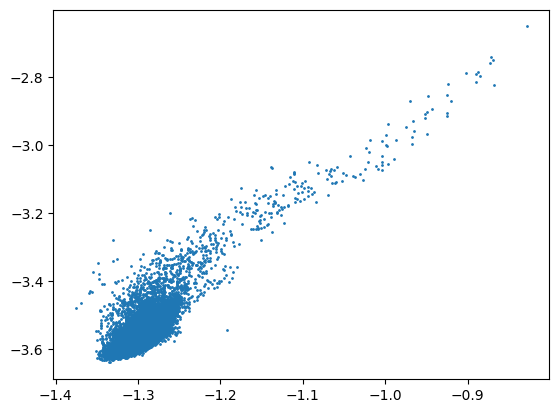

In [ ]:
plt.scatter(leaf_array[:,0],leaf_array[:,1],s=1)
plt.show()

### plot latent space

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import manifold
from time import time


%matplotlib inline

n_components = 2
perplexity = 30

movements = np.load("keypoint_hidden_array.npy")

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='random', n_iter=5000,
                        random_state=0, perplexity=perplexity)
X = tsne.fit_transform(movements)


cow movements, perplexity=30 in 1.2e+03 sec


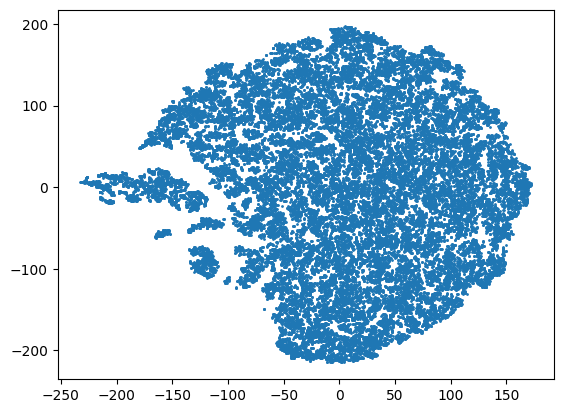

<Figure size 640x480 with 0 Axes>

In [ ]:
t1 = time()
print("cow movements, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
plt.scatter(X[:, 0], X[:, 1],s=1)
plt.show()
plt.savefig('./t_SNE.png')

In [ ]:
np.save("t-sne_1worker.npy",X)